# Project 2 Notebook

Imported necessary libraries

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score

## Defining Functions and Feature Engineering

Created functions for the model assessments

In [2]:
def sm_metrics(model, y, X):
    # import associated tools
    from statsmodels.tools.eval_measures import rmse, mse, meanabs
    
    # now generate predictions
    ypred = model.predict(X)

    # Print values
    print('Metrics:')
    # MAE
    print(f"Mean Absolute Error: {meanabs(y, ypred):.3f}")
    # MSE
    print(f"Mean Squared Error: {mse(y, ypred):.3f}")
    # RMSE
    print(f"Root Mean Squared Error: {rmse(y, ypred):.3f}")
    return

In [3]:
def qq(x_test, x_train, y_test, y_train):
    # QQ plots are generally great tools for checking for normality.
    import statsmodels.api as sm
    from sklearn.linear_model import LinearRegression
    
    # Calculating residuals
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_hat = lr.predict(x_test)
    
    residuals = y_test - y_hat
    
    
    sm.qqplot(residuals, line = 'r');
    return

In [4]:
# evaluates the Variance Inflation Factor of X_train variables

def vif(X_train):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # defining an empty dataframe to capture the VIF scores
    vif = pd.DataFrame()

    # For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

    # label the scores with their related columns
    vif["features"] = X_train.columns
    
    # print out the vif table and return
    print(vif)
    return

Loaded in the kc_house_data.csv using pandas library

In [5]:
housedf = pd.read_csv('data/kc_house_data.csv')


In [6]:
housedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [7]:
housedf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [8]:
housedf.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Created a few dataframes for different use cases:
- **dfinit**: used to drop columns that we were not utilizing in our model/data analysis (mostly categorical columns)
- **dfrev1**: used to drop numerical columns
- **dfrevcopy**: used for testing some modeling so that I didn't have to re-run everything when I made a mistake

Also added some features to the original housedf:
- **sqft_per_bedroom**: the sqft_living divided by bedrooms value for avg sqft per bedroom
- **footprint**: the sqft_living divided by sqft_lot for relative sqft of usage
- **bedbathratio**: the number of bedrooms divided by bathrooms since these values have high multicollinearity

In [9]:
dfinit = housedf.drop(['id', 'date', 'yr_renovated', 'condition', 'waterfront', 'lat', 'long', 
                 'sqft_above', 'sqft_basement', 'view'], axis=1).copy()

dfrev1 = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
dfrevcopy = dfinit.drop(['sqft_living15', 'sqft_lot15'], axis=1).copy()
# Feature engineered sqft_per_bedroom as a data column since for our stakeholder, knowing the avg sqft per bedroom in a home
# would be useful in deciding which direction to go for homebuilding.
housedf['sqft_per_bedroom'] = housedf['sqft_living'] / housedf['bedrooms']
# Feature engineered the footprint column to visualized the relationship between sqft of living and the lot size so that our 
# stakholder would know on avg what home sizes they would be working with.
housedf['footprint'] = housedf['sqft_living'] / housedf['sqft_lot']
# Feature engineered the bedbathratio since they have decently high multicollinearity - combining them together in the bed/bath
# ratio might give us a better R^2 value
housedf['bedbathratio'] = housedf['bedrooms'] / housedf['bathrooms']
housedf

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint,bedbathratio
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,393.333333,0.208850,3.000000
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,856.666667,0.354874,1.333333
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,385.000000,0.077000,2.000000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,490.000000,0.392000,1.333333
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,560.000000,0.207921,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,2009,0.0,98103,47.6993,-122.346,1530,1509,510.000000,1.352785,1.200000
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2014,0.0,98146,47.5107,-122.362,1830,7200,577.500000,0.397385,1.600000
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,2009,0.0,98144,47.5944,-122.299,1020,2007,510.000000,0.755556,2.666667
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,2004,0.0,98027,47.5345,-122.069,1410,1287,533.333333,0.670017,1.200000


We load in the demographic XLS file from which we pulled this list of unique Zipcode values that we defined as kc_zips.

In [10]:
kc_zips = [98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198,
           98146, 98038, 98007, 98115, 98107, 98126, 98019, 98103, 
           98002, 98133, 98040, 98092, 98030, 98119, 98112, 98052, 
           98027, 98117, 98058, 98001, 98056, 98166, 98023, 98070, 
           98148, 98105, 98042, 98008, 98059, 98122, 98144, 98004, 
           98005, 98034, 98075, 98116, 98010, 98118, 98199, 98032, 
           98045, 98102, 98077, 98108, 98168, 98177, 98065, 98029, 
           98006, 98109, 98022, 98033, 98155, 98024, 98011, 98031, 
           98106, 98072, 98188, 98014, 98055, 98039]

In [11]:
df2 = pd.read_excel('data/demographic_spatial_join.xls')

b_series = df2.ZCTA5CE10.isin(kc_zips)
df_zips = df2[b_series]

df_names = df_zips[['ZCTA5CE10', 'NAME']]
df_names.head()


,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest


In [12]:
df_names.NAME.value_counts()

Northeast    33
West         29
Southeast    26
Southwest    17
Shoreline    12
Name: NAME, dtype: int64

In [13]:
df_names

,ZCTA5CE10,NAME
0,98001,Southeast
1,98001,Southwest
2,98002,Southeast
3,98003,Southeast
4,98003,Southwest
...,...,...
138,98188,Southeast
139,98188,Southwest
141,98198,Southeast
142,98198,Southwest


In [14]:
# Dropping duplicates randomly, for the moment
df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)
df_names.ZCTA5CE10

<ipython-input-14-af7d0a158eea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_names.drop_duplicates(subset=['ZCTA5CE10'], inplace=True)


0      98001
2      98002
3      98003
5      98004
6      98005
       ...  
131    98177
135    98178
138    98188
141    98198
143    98199
Name: ZCTA5CE10, Length: 70, dtype: int64

In [15]:
# lists of zipcodes
northeast = df_names.query('NAME=="Northeast"')['ZCTA5CE10'].to_list()
west = df_names.query('NAME=="West"')['ZCTA5CE10'].to_list()
shoreline = df_names.query('NAME=="Shoreline"')['ZCTA5CE10'].to_list()
southwest = df_names.query('NAME=="Southwest"')['ZCTA5CE10'].to_list()
southeast = df_names.query('NAME=="Southeast"')['ZCTA5CE10'].to_list()
print("Northeast: ", northeast)
print("Shoreline: ", shoreline)

Northeast:  [98004, 98005, 98006, 98007, 98008, 98011, 98014, 98019, 98024, 98027, 98028, 98029, 98033, 98034, 98038, 98039, 98040, 98045, 98052, 98053, 98056, 98059, 98065, 98072, 98074, 98075, 98077]
Shoreline:  [98125, 98133, 98155, 98177]


In [16]:
# Create new  DF for revisions, change type
dfrev2 = dfrev1.copy()
#dfrev2 = dfrev2.astype({"zipcode": str})
# use lists to make categorical bins
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=northeast, value = "Northeast")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=west, value = "West")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=shoreline, value = "Shoreline")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southwest, value = "Southwest")
dfrev2['zipcode'] = dfrev2.zipcode.replace(to_replace=southeast, value = "Southeast")

dfrev2.zipcode.value_counts()

Northeast    8560
West         4442
Southeast    4126
Southwest    2866
Shoreline    1603
Name: zipcode, dtype: int64

# Correlation and Heatmap Visualization

Visualized correlation between variables using .corr() method, then plotted the correlation out for easier visualization on
the sns.heatmap

In [17]:
housedf.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_per_bedroom,footprint,bedbathratio
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557,-0.011922,0.088238,-0.014457
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845,0.580109,0.123063,-0.249948
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690,-0.024076,0.026798,0.209444
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303,0.517415,0.287015,-0.653476
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342,0.755398,0.076988,-0.324152
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204,0.190583,-0.252601,-0.050648
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722,0.290654,0.556700,-0.374139
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077,0.671149,0.051612,-0.317922
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777,0.257801,0.279053,-0.437429
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852,0.063348,-0.001743,-0.034499


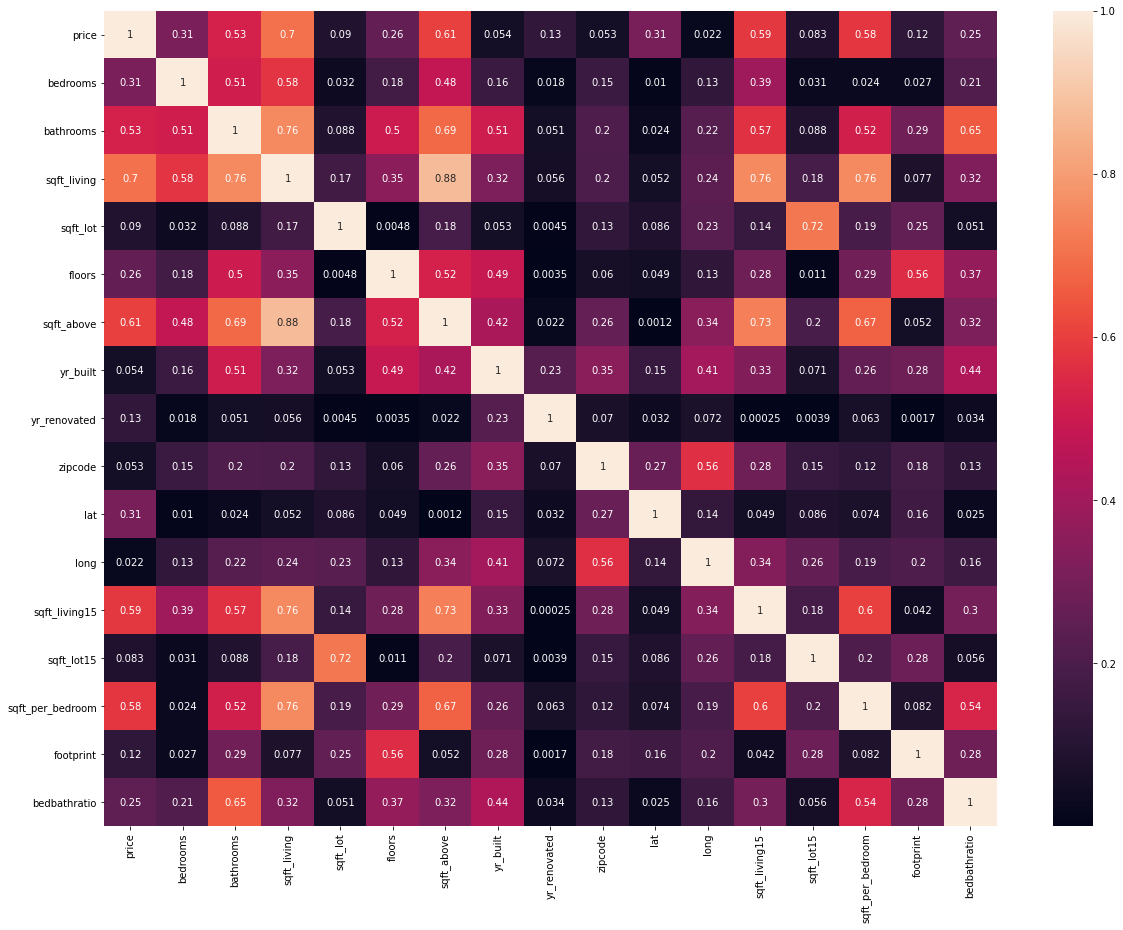

In [18]:
plt.figure(figsize = (20,15))
sns.heatmap(housedf.drop(['id'], axis = 1).corr().abs(), annot=True);

# Model Creation and Application

Created training and test datasets for the housedf dataframe. Utilized a 80 / 20 split. Dropped any rows that were duplicates of each other.

In [19]:
housedf.drop_duplicates(keep = 'first', inplace = True)
y = housedf['price']
X = housedf[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode',\
             'sqft_per_bedroom', 'footprint', 'bedbathratio']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

## Dummy Regressor

Created a Dummy Regressor on the mean for use as our baseline model. 
- We used the predict function and saw that it printed out an array filled with the same values
- We then checked the score to see that it gave us a 0 value, so we know that this is the baseline we will compare our other models to.

In [20]:
#Dummy Regressor

basemodel = DummyRegressor(strategy = 'mean')
basemodel.fit(X_train, y_train)
basemodel.predict(X_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

In [21]:
basemodel.score(X_train, y_train)

0.0

## StandardScaler and OneHotEncoder

Created a StandardScalar for our dataset because we had data values such as 1 bedroom vs. thousands of sqft

In [22]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

Created a OneHotEncoder for our initial model 

In [23]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train)

<17277x26611 sparse matrix of type '<class 'numpy.float64'>'
	with 172770 stored elements in Compressed Sparse Row format>

Created a training data sat based on the StandardScalar values and our training/test split

In [24]:
# Training dataset
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X.columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_plus_y = pd.concat((X_train_scaled, y_train), axis=1)
X_train.reset_index(drop=True, inplace=True)
X_train_plus_y = pd.concat((X_train, y_train), axis=1)

In [25]:
# Checked to see if the standardscalar worked correctly
X_train_scaled

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint,bedbathratio
0,-0.404166,-0.148210,-0.591864,-0.174771,-0.917505,1.123192,0.882599,-0.484799,-0.470293,-0.383342
1,0.670108,0.832246,0.489562,-0.020598,0.937801,0.884897,-1.105526,0.066728,-0.540972,-0.451815
2,-0.404166,0.178609,-0.307853,-0.201845,0.937801,0.408307,-0.824188,-0.083688,-0.202228,-0.634408
3,0.670108,0.505427,0.631567,-0.274556,0.937801,-2.076770,0.507481,0.217145,1.490978,-0.232702
4,0.670108,0.832246,2.128085,-0.115790,0.937801,-0.953379,1.857905,1.802302,0.259627,-0.451815
...,...,...,...,...,...,...,...,...,...,...
17272,-1.478441,0.178609,-0.482629,-0.309172,0.937801,0.306180,1.032646,0.934515,1.519793,-1.303919
17273,1.744382,1.485883,1.319747,-0.208081,0.937801,1.395529,-0.073952,0.184747,0.701581,-0.325404
17274,-0.404166,1.485883,1.778533,0.567548,0.937801,0.918939,-1.199306,2.862930,-0.846551,-1.252418
17275,0.670108,-0.475029,-0.602787,-0.151807,0.010148,-0.102325,-0.374046,-1.090321,-0.554328,0.800257


Created the test dataset based on our StandardScalar values and our training/test split

In [26]:
# Testing dataset
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X.columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_plus_y = pd.concat((X_test_scaled,y_test),axis=1)

## First Model

Created our first model based on the values in our heatmap that had the highest correlation with price, in this case that was the sqft_living + bedrooms + floors columns. We will then use this first model to check and see if the predictors have any significant impact on the price of the homes.

In [27]:
# Keep first model as sqft_living + bedrooms + floors to show that was our first model and how we progressed
# 2nd model should be 'price ~ sqft_living + bedrooms + sqft_per_bedroom + footprint' to show the increase of R^2
formula = 'price ~  sqft_living + bedrooms + floors'
model = ols(formula, X_train_scaled_plus_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5874.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:19:22   Log-Likelihood:            -2.3986e+05
No. Observations:               17277   AIC:                         4.797e+05
Df Residuals:                   17273   BIC:                         4.798e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.409e+05   1970.511    274.521      0.000    5.37e+05    5.45e+05
sqft_living  2.882e+05   2530.414    113.894      0.000    2.83e+05    2.93e+05
bedrooms    -5.411e+04   2402.875    -22.520      0.000   -5.88e+04   -4.94e+04
floors       1412.8026   2110.123      0.670      0.503   -2723.252    5548.857
==============================================================================
Omnibus:                    11809.269   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           435749.399
Skew:                           2.803   Prob(JB):                         0.00
Kurtosis:                      26.956   Cond. No.                         2.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After running the model, we see that sqft_living and bedrooms are a significant factor in determining the price of a home. Since the p-value of floors > 0.05, we can say that floors are not a significant factor in determining the price of a home. This pertains to our business question since the lots of land themselves are expensive, but homes are cheaper to build vertically.

Called the functions we defined earlier to find the metrics of our model. We prioritize/focus on RMSE because it provides us with more accuracy. The values in this case make sense since we are dealing with homes that are in the hundreds of thousands range.

In [28]:
sm_metrics(model, y_test, X_test_scaled)

Metrics:
Mean Absolute Error: 169584.127
Mean Squared Error: 64475389966.508
Root Mean Squared Error: 253920.046


We then calculate the predicted values of our models to calculate the residuals and see if our models were implemented correctly.

In [29]:
y_hat = model.predict(X_train_scaled)
y_pred = model.predict(X_test_scaled_plus_y)
y_hat_t = model.predict(X_train_scaled)

We calculate the residuals

In [30]:
# y_pred = model.predict(X_test)
residuals = (y_train - y_hat)
#print(type(y_pred))
#print(type(y_test))
print(residuals)

0        134054.190256
1       -177151.427931
2        -39418.666228
3        211972.734232
4       -284322.633742
             ...      
17272   -108179.962734
17273    -18228.613749
17274   -141713.668295
17275    -61076.700318
17276     34848.286680
Length: 17277, dtype: float64


Then we plot on a qqplot to visualize the residuals and see where our error lies

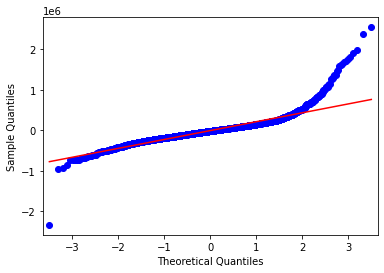

In [31]:
qq(X_test_scaled, X_train_scaled, y_test, y_train)

Plotted a heteroskedasticity plot for visualization of any recognizable patterns to check if our model was ran correctly.

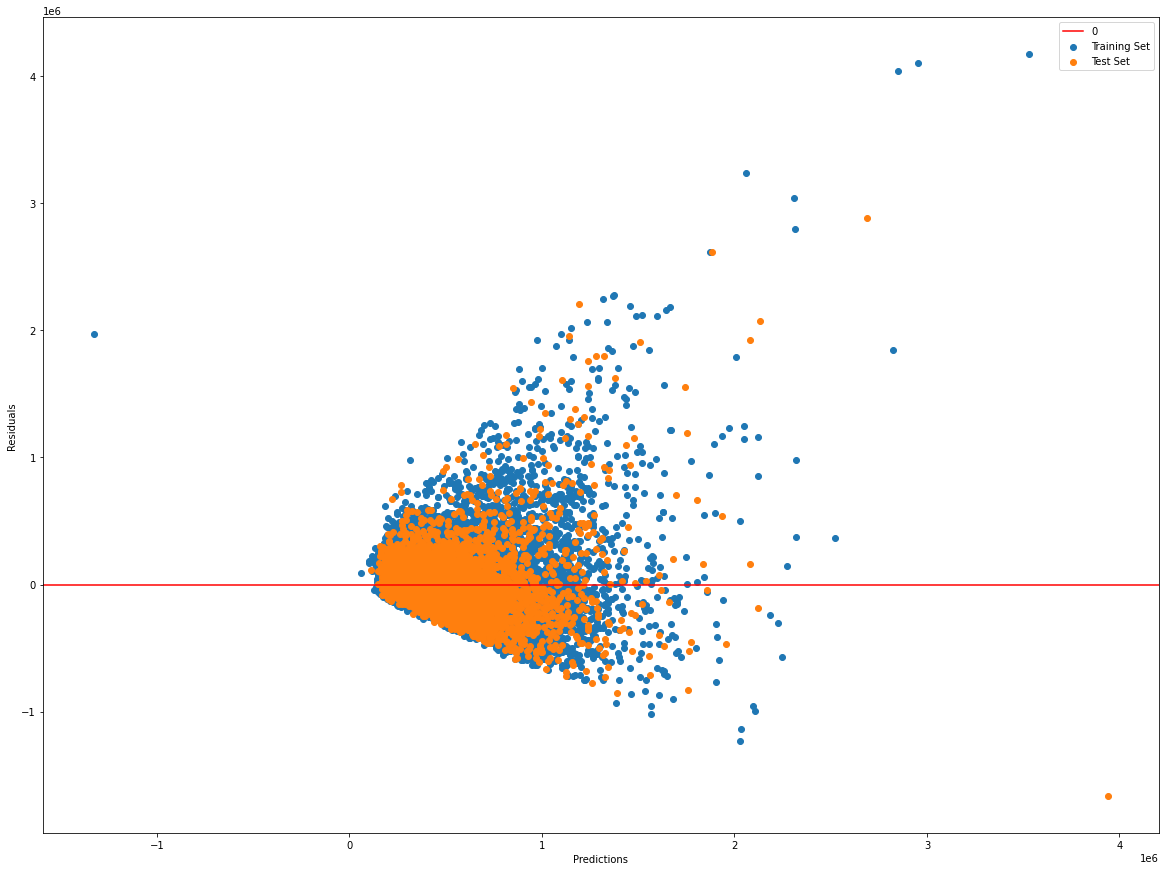

In [32]:
plt.figure(figsize = (20,15))
plt.scatter(y_hat, y_train - y_hat, label = 'Training Set')
plt.scatter(y_pred, y_test - y_pred, label = 'Test Set')

plt.axhline(y = 0, color = 'red', label = '0')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [33]:
X_train_scaled.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode,sqft_per_bedroom,footprint,bedbathratio
bedrooms,1.000000,0.509423,0.571636,0.026344,0.178529,0.154396,-0.152053,-0.024644,0.030371,0.217513
bathrooms,0.509423,1.000000,0.752564,0.085556,0.503355,0.511066,-0.205060,0.517643,0.289180,-0.653090
sqft_living,0.571636,0.752564,1.000000,0.170260,0.356378,0.320881,-0.201041,0.759121,0.077961,-0.324053
sqft_lot,0.026344,0.085556,0.170260,1.000000,-0.001869,0.053034,-0.128976,0.194870,-0.250546,-0.049564
floors,0.178529,0.503355,0.356378,-0.001869,1.000000,0.488497,-0.058795,0.293768,0.553484,-0.373462
yr_built,0.154396,0.511066,0.320881,0.053034,0.488497,1.000000,-0.347291,0.261316,0.279235,-0.440836
zipcode,-0.152053,-0.205060,-0.201041,-0.128976,-0.058795,-0.347291,1.000000,-0.124074,0.177918,0.126029
sqft_per_bedroom,-0.024644,0.517643,0.759121,0.194870,0.293768,0.261316,-0.124074,1.000000,0.080342,-0.537891
footprint,0.030371,0.289180,0.077961,-0.250546,0.553484,0.279235,0.177918,0.080342,1.000000,-0.278224
bedbathratio,0.217513,-0.653090,-0.324053,-0.049564,-0.373462,-0.440836,0.126029,-0.537891,-0.278224,1.000000


We then check the VIF to see if we missed anything about multicollinearity between the variables.

In [34]:
vif(X_train_scaled)

         VIF          features
0   8.133196          bedrooms
1  10.414278         bathrooms
2  15.034290       sqft_living
3   1.142210          sqft_lot
4   1.955622            floors
5   1.739823          yr_built
6   1.276777           zipcode
7   9.195762  sqft_per_bedroom
8   1.764403         footprint
9   6.343995      bedbathratio


In [35]:
formula = 'price ~  sqft_living + sqft_per_bedroom + footprint + bedbathratio'
model = ols(formula, X_train_scaled_plus_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     4354.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:19:24   Log-Likelihood:            -2.3992e+05
No. Observations:               17277   AIC:                         4.798e+05
Df Residuals:                   17272   BIC:                         4.799e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.409e+05   1976.419    273.700      0.000    5.37e+05    5.45e+05
sqft_living       2.203e+05   3080.842     71.492      0.000    2.14e+05    2.26e+05
sqft_per_bedroom  5.374e+04   3469.775     15.489      0.000    4.69e+04    6.05e+04
footprint         2.854e+04   2070.744     13.781      0.000    2.45e+04    3.26e+04
bedbathratio        1.7e+04   2476.960      6.865      0.000    1.21e+04    2.19e+04
==============================================================================
Omnibus:                    12444.927   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           551350.015
Skew:                           2.973   Prob(JB):                         0.00
Kurtosis:                      30.029   Cond. No.                         3.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We now run the second model to see if there were any changes to the R^2 value. We also wanted to test and see if keeping the bedrooms/bathrooms variables would reduce the complexity of our models. Removing the bedrooms variable in our model reduces our R^2 value by 0.015. 

In [36]:
formula = 'price ~  sqft_living + bedrooms + sqft_per_bedroom + footprint + bedbathratio'
model = ols(formula, X_train_scaled_plus_y).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     3698.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:19:24   Log-Likelihood:            -2.3965e+05
No. Observations:               17277   AIC:                         4.793e+05
Df Residuals:                   17271   BIC:                         4.794e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.409e+05   1946.540    277.902      0.000    5.37e+05    5.45e+05
sqft_living       3.717e+05   7215.335     51.518      0.000    3.58e+05    3.86e+05
bedrooms         -1.111e+05   4800.357    -23.137      0.000    -1.2e+05   -1.02e+05
sqft_per_bedroom   -5.6e+04   5846.160     -9.579      0.000   -6.75e+04   -4.45e+04
footprint         3.324e+04   2049.527     16.217      0.000    2.92e+04    3.73e+04
bedbathratio      3.252e+04   2530.002     12.853      0.000    2.76e+04    3.75e+04
==============================================================================
Omnibus:                    11442.493   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           377466.535
Skew:                           2.710   Prob(JB):                         0.00
Kurtosis:                      25.248   Cond. No.                         7.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ran a model on our test data to see what the results were (not sure if right)


In [37]:
testmodel = ols(formula, X_test_scaled_plus_y).fit()
testmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     950.1
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        11:19:24   Log-Likelihood:                -59848.
No. Observations:                4320   AIC:                         1.197e+05
Df Residuals:                    4314   BIC:                         1.197e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.395e+05   3828.825    140.897      0.000    5.32e+05    5.47e+05
sqft_living       3.634e+05   1.49e+04     24.387      0.000    3.34e+05    3.93e+05
bedrooms         -1.072e+05   1.05e+04    -10.175      0.000   -1.28e+05   -8.65e+04
sqft_per_bedroom -5.744e+04   1.21e+04     -4.765      0.000   -8.11e+04   -3.38e+04
footprint         3.053e+04   4039.809      7.557      0.000    2.26e+04    3.84e+04
bedbathratio      2.139e+04   4904.734      4.362      0.000    1.18e+04     3.1e+04
==============================================================================
Omnibus:                     2502.105   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55139.420
Skew:                           2.325   Prob(JB):                         0.00
Kurtosis:                      19.873   Cond. No.                         8.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We then see that our R^2 value increases and we check our RMSE to see if the values make sense to us.

In [38]:
sm_metrics(model, y_test, X_test_scaled)

Metrics:
Mean Absolute Error: 166122.785
Mean Squared Error: 63292077990.497
Root Mean Squared Error: 251579.168


## Training/Test split to see if these new predictors are relevant to our model

We then created a new training/test split to see if we should add these predictors to our model or not. We did not want to affect our original model so we created a new test model to see the effect of adding another categorical column 'grade' to our dataframe.

In [39]:
y1 = dfrev2['price']
X1 = dfrev2[['bedrooms','bathrooms','sqft_living','sqft_lot','floors', 'yr_built', 'zipcode','grade']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=56)

Created DummyRegressor similar to how we did it for our first model.

In [40]:
# ss1 = StandardScaler()
# ss1.fit(X1_train)

# X1_train_scaled = ss1.transform(X1_train)
# X1_test_scaled = ss1.transform(X1_test)

#Dummy Regressor

basemodel1 = DummyRegressor(strategy = 'mean')
basemodel1.fit(X1_train, y1_train)
basemodel1.predict(X1_train)

array([540946.37500724, 540946.37500724, 540946.37500724, ...,
       540946.37500724, 540946.37500724, 540946.37500724])

Dropped the numerical columns from our dataframe so that we could only focus on and OneHotEncode the categorical values we pulled from our demographics XLS

In [41]:
ohe1 = OneHotEncoder(drop = 'first')
grade_transform = ohe1.fit_transform(X1_train.drop(['bedrooms','bathrooms','sqft_living','sqft_lot','yr_built'], axis = 1))

Checked to see if we did the OHE correctly

In [42]:
# Created column_names to retrieve the categorical feature names from the data we passed in
column_names = ohe1.get_feature_names()

In [43]:
# Checked to see the if OHE was ran correctly and that it didn't generate more columns than necessary
len(column_names)

18

In [44]:
# Checked to see if the OHE was ran correctly
pd.get_dummies(X1_train)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,zipcode_Northeast,zipcode_Shoreline,zipcode_Southeast,zipcode_Southwest,...,grade_10 Very Good,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
8192,3,2.00,1540,7800,1.0,2004,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
18780,4,2.75,2530,14178,2.0,1997,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4957,3,2.25,1800,6680,2.0,1983,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1168,4,2.50,2660,3672,2.0,1910,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15335,4,2.75,4030,10240,2.0,1943,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9338,2,2.25,1640,2240,2.0,1980,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
13730,5,3.25,3290,6422,2.0,2012,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3264,3,3.25,3710,38509,2.0,1998,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
399,4,1.75,1530,8750,1.5,1968,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Created a dataframe with the new OHE values for our categorical columns from housedf, ad we added the price column from our original dataframe to the OHE dataframe to check for correlation between these variables and if they had an effect on home pricing.

In [45]:
dfrev3 = pd.DataFrame(grade_transform.todense(), columns=ohe1.get_feature_names())
dfrev3.head()

,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,x1_Shoreline,x1_Southeast,x1_Southwest,x1_West,x2_11 Excellent,x2_12 Luxury,x2_13 Mansion,x2_4 Low,x2_5 Fair,x2_6 Low Average,x2_7 Average,x2_8 Good,x2_9 Better
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
dfrev3['price'] = dfrev2['price']

In [47]:
dfrev3.corr()

,x0_1.5,x0_2.0,x0_2.5,x0_3.0,x0_3.5,x1_Shoreline,x1_Southeast,x1_Southwest,x1_West,x2_11 Excellent,x2_12 Luxury,x2_13 Mansion,x2_4 Low,x2_5 Fair,x2_6 Low Average,x2_7 Average,x2_8 Good,x2_9 Better,price
x0_1.5,1.000000,-0.244638,-0.027479,-0.052485,-0.005793,0.002665,-0.047916,0.022100,0.212288,-0.031011,-0.019681,-0.007845,-0.000626,0.024247,0.061949,0.079705,-0.053611,-0.061178,-0.003325
x0_2.0,-0.244638,1.000000,-0.069588,-0.132912,-0.014670,-0.134179,-0.025883,-0.108511,-0.096946,0.122443,0.052127,0.013183,-0.029356,-0.081632,-0.233467,-0.290405,0.147202,0.272373,0.003823
x0_2.5,-0.027479,-0.069588,1.000000,-0.014930,-0.001648,-0.014904,-0.027539,-0.022950,0.080418,0.050892,0.015324,0.050082,-0.003297,-0.009298,-0.023704,-0.061579,0.013974,0.036483,-0.005008
x0_3.0,-0.052485,-0.132912,-0.014930,1.000000,-0.003147,0.049256,-0.077959,-0.049492,0.220447,0.007757,-0.005103,-0.004262,-0.006298,-0.017759,-0.053966,-0.083843,0.124852,0.012636,0.000354
x0_3.5,-0.005793,-0.014670,-0.001648,-0.003147,1.000000,-0.005268,-0.009002,0.001854,0.028867,-0.002581,0.048074,-0.000470,-0.000695,-0.001960,-0.005957,-0.015802,0.022984,-0.006875,-0.004323
x1_Shoreline,0.002665,-0.134179,-0.014904,0.049256,-0.005268,1.000000,-0.136507,-0.110646,-0.144162,-0.037506,-0.007378,0.019168,-0.010541,-0.014841,0.040858,0.067950,-0.013586,-0.060654,-0.012151
x1_Southeast,-0.047916,-0.025883,-0.027539,-0.077959,-0.009002,-0.136507,1.000000,-0.189083,-0.246360,-0.054909,-0.028241,-0.012191,0.013731,0.021668,0.028627,0.100784,-0.026789,-0.066623,-0.008643
x1_Southwest,0.022100,-0.108511,-0.022950,-0.049492,0.001854,-0.110646,-0.189083,1.000000,-0.199686,-0.041655,-0.016679,-0.009881,0.008289,0.039150,0.214182,0.020687,-0.065107,-0.077702,-0.005714
x1_West,0.212288,-0.096946,0.080418,0.220447,0.028867,-0.144162,-0.246360,-0.199686,1.000000,-0.029576,-0.018695,-0.001537,-0.015185,-0.020650,-0.037254,0.033725,0.036626,-0.022535,0.000227
x2_11 Excellent,-0.031011,0.122443,0.050892,0.007757,-0.002581,-0.037506,-0.054909,-0.041655,-0.029576,1.000000,-0.008768,-0.003495,-0.005164,-0.014562,-0.044250,-0.117388,-0.086302,-0.051071,0.003529


In [48]:
df_corrs = dfrev3.corr()['price'].map(abs).sort_values(ascending=False)
df_corrs

price               1.000000
x1_Shoreline        0.012151
x1_Southeast        0.008643
x2_4 Low            0.008474
x2_6 Low Average    0.005719
x1_Southwest        0.005714
x0_2.5              0.005008
x0_3.5              0.004323
x2_12 Luxury        0.004233
x0_2.0              0.003823
x2_11 Excellent     0.003529
x0_1.5              0.003325
x2_13 Mansion       0.002502
x2_9 Better         0.002145
x2_7 Average        0.001758
x2_5 Fair           0.000743
x2_8 Good           0.000586
x0_3.0              0.000354
x1_West             0.000227
Name: price, dtype: float64

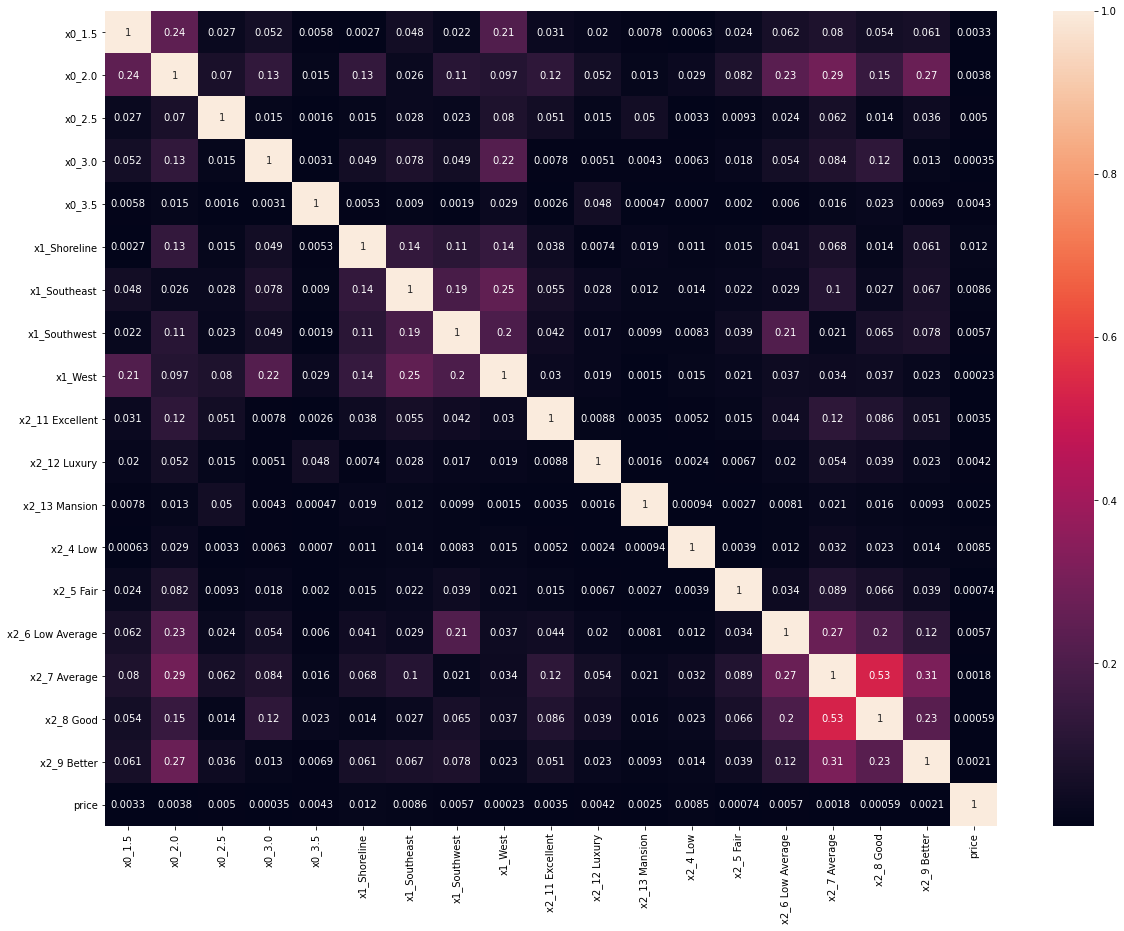

In [49]:
plt.figure(figsize = (20, 15))
sns.heatmap(dfrev3.corr().abs(), annot=True);

As we can see from the df_corrs and the heatmap generated above, there is little to no correlation between the categorical variables we identified (grade/zipcode/floors) and their effect on price.